# Regridding with [xESMF](https://github.com/pangeo-data/xESMF)

In [1]:
# Some necessary steps when using a custom conda environment with pyproj and CDO installed
import conda, os
conda_file_dir = conda.__file__
conda_dir = conda_file_dir.split('lib')[0]
proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
os.environ["PROJ_LIB"] = proj_lib
os.environ['PATH'] += os.pathsep + os.path.join(conda_dir, 'bin')

# Import necessary python modules
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import xesmf as xe
from pathlib import Path
# depends on git+https://github.com/roocs/clisops/@regrid-main#egg=clisops
from clisops.ops.subset import subset

## Prepare data


### Input data


We select two datasets:

*  near surface air temperature (2D) on a rectilinear grid
*  sea surface temperature (2D) on a curvilinear grid

Before creating the remapping weights, we subselect the region around Europe. For that we will use clisops, 
since xarray cannot subset variables with 2D coordinate variables by their value. Also xarray cannot automatically wrap
longitude axis when subsetting across the 0-meridian (or in general: across the easter and western bounds of the grid).

In [2]:
###########################################################################
# Specify input files, download if not working on levante, load via xarray:
###########################################################################

cmip_root = "/work/ik1017/CMIP6/data"

# near surface air temperature
infile_tas = "tas_Amon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-185412.nc"
path_tas = Path(cmip_root,  
                "CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Amon/tas/gn/v20190710",
                infile_tas)
ds_tas_global = xr.open_dataset(path_tas)

# ocean surface temperature
infile_tos = "tos_Omon_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001-185412.nc"
path_tos = Path(cmip_root,
                "CMIP6/CMIP/MPI-M/MPI-ESM1-2-HR/historical/r1i1p1f1/Omon/tos/gn/v20190710",
                infile_tos)
ds_tos_global = xr.open_dataset(path_tos)

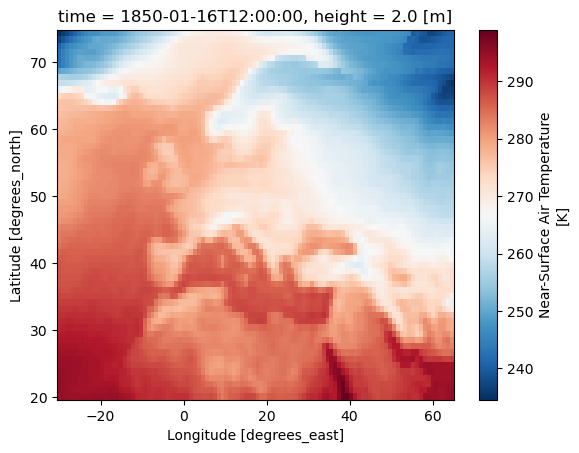

In [3]:
# Subset near surface air temperature
# area is specified as a tuple (lon_lower, lat_lower, lon_upper, lat_upper)
ds_tas = subset(ds=ds_tas_global, area=(-30, 20, 65, 75), output_type="xarray")[0]

# Plot
ds_tas.tas.isel(time=0).plot.pcolormesh(x="lon", y="lat", shading="auto", cmap="RdBu_r");

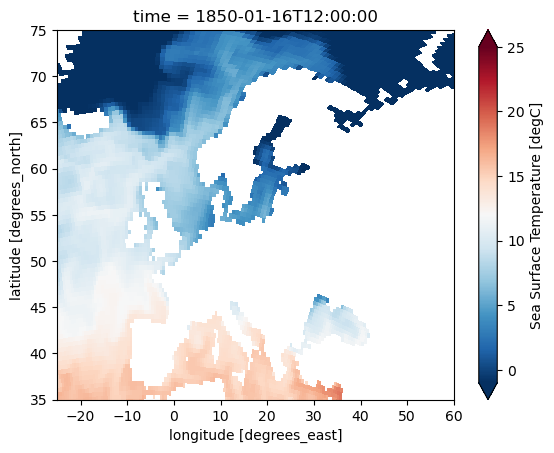

In [4]:
# Subset sea surface temperature
# area is specified as a tuple (lon_lower, lat_lower, lon_upper, lat_upper)
ds_tos = subset(ds=ds_tos_global, area=(-30, 20, 65, 75), output_type="xarray")[0]

# Plot
ds_tos["tos"].isel(time=0).plot.pcolormesh(x="longitude", y="latitude", shading="auto",
                                           cmap="RdBu_r", vmin = -1, vmax=25, 
                                           xlim=(-25,60), ylim=(35,75));

### Target grid

We use xESMF to create a regular Grid with `1.0°x1.0°` resolution.
A little smaller domain is selected for the output, 
to avoid problems like missing values at the domain bounds.



In [5]:
# Create a regional regular latitude longitude grid of 1 degree resolution
#  xe.util.cf_grid_2d(lon0_b, lon1_b, d_lon, lat0_b, lat1_b, d_lat)
ds_out = xe.util.cf_grid_2d(-25, 60, 1, 35, 70, 1)

# alternatively create a global target grid:
#ds_out = xe.util.grid_global(d_lat=1, d_lon=1, cf=True)

# altneratively use clisops to create the target grid:
#from clisops.core.regrid import Grid
#ds_out = Grid(grid_instructor=(-25,60,1,35,70,1)).ds
#ds_out = Grid(grid_instructor=1)
#ds_out = Grid(grid_id="1deg").ds

# display ds_out
ds_out

<xarray.Dataset>
Dimensions:             (bound: 2, lon: 85, lat: 35)
Coordinates:
  * lon                 (lon) float64 -24.5 -23.5 -22.5 -21.5 ... 57.5 58.5 59.5
  * lat                 (lat) float64 35.5 36.5 37.5 38.5 ... 67.5 68.5 69.5
    latitude_longitude  float64 nan
Dimensions without coordinates: bound
Data variables:
    lon_bounds          (bound, lon) int64 -25 -24 -23 -22 -21 ... 57 58 59 60
    lat_bounds          (bound, lat) int64 35 36 37 38 39 40 ... 66 67 68 69 70

## Perform regridding

We create the regridding weights by calling `xe.Regridder(grid_in, grid_out, method)`. A `grid` is just an
xarray `DataSet` containing `latitude` and `longitude` coordinates.

xESMF supports multiple remapping methods, but [which method should be applied for the problem](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview)?

<table style="align:left !important; margin-left:0 !important;">
<thead>
  <tr>
    <th >Method</th>
    <th >Description</th>
    <th >Application</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>bilinear</td>
    <td><ul><li>linear interpolation</li><li>monotonic (i.e. creates no new maxima/minima)</li></ul></td>
    <td>smoothly varying variables (eg. temperature)</td>
  </tr>
  <tr>
    <td>conservative</td>
    <td><ul><li>preserving area average</li><li>maintaining eg. energy budgets</li><li>monotonic</li></ul></td>
    <td><ul><li>discontinuous variables / fluxes</li><li>upscaling (remapping to coarser grid)</li></ul> </td>
  </tr>
  <tr>
    <td>nearest neighbour</td>
    <td>monotonic</td>
    <td>categorical data (eg. binary masks, land usage type)</td>
  </tr>
  <tr>
    <td>patch</td>
      <td><ul><li>least square fit of surrounding surface patches</li><li>preserving derivatives<li</td>
    <td>eg. wind speed</td>
  </tr>
</tbody>
</table>


In [6]:
# Calculation of weights, using xesmf.Regridder
method_list = ["bilinear",
               "conservative",
               "conservative_normed",
               "patch",
               "nearest_s2d",
               "nearest_d2s"]

regridder = {}
for method in method_list:
    print("\n"+method)
    %time regridder[method+"_tas"] = xe.Regridder(ds_tas, ds_out, method)
    %time regridder[method+"_tos"] = xe.Regridder(ds_tos, ds_out, method)


bilinear
CPU times: user 75.5 ms, sys: 41.3 ms, total: 117 ms
Wall time: 64.4 ms


/home/k/k202015/.conda/envs/sschool/lib/python3.10/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


CPU times: user 176 ms, sys: 0 ns, total: 176 ms
Wall time: 176 ms

conservative
CPU times: user 159 ms, sys: 0 ns, total: 159 ms
Wall time: 159 ms
CPU times: user 386 ms, sys: 1.9 ms, total: 388 ms
Wall time: 389 ms

conservative_normed
CPU times: user 157 ms, sys: 5 µs, total: 157 ms
Wall time: 157 ms
CPU times: user 383 ms, sys: 605 µs, total: 383 ms
Wall time: 384 ms

patch
CPU times: user 883 ms, sys: 0 ns, total: 883 ms
Wall time: 886 ms
CPU times: user 980 ms, sys: 0 ns, total: 980 ms
Wall time: 983 ms

nearest_s2d
CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 13.9 ms
CPU times: user 39.8 ms, sys: 0 ns, total: 39.8 ms
Wall time: 40 ms

nearest_d2s
CPU times: user 21.1 ms, sys: 0 ns, total: 21.1 ms
Wall time: 21.2 ms
CPU times: user 98.9 ms, sys: 0 ns, total: 98.9 ms
Wall time: 99.2 ms


In [7]:
# Applying the weights to remap the data
for method in method_list:
    ds_out[method+"_tas"] = regridder[method+"_tas"](ds_tas.tas.isel(time=0))
    ds_out[method+"_tos"] = regridder[method+"_tos"](ds_tos.tos.isel(time=0))

/home/k/k202015/.conda/envs/sschool/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')
/home/k/k202015/.conda/envs/sschool/lib/python3.10/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not C_CONTIGUOUS. ' 'Will affect performance.')


## Plot the results

The regridding result is consistent with the original data, with a much finer
resolution:


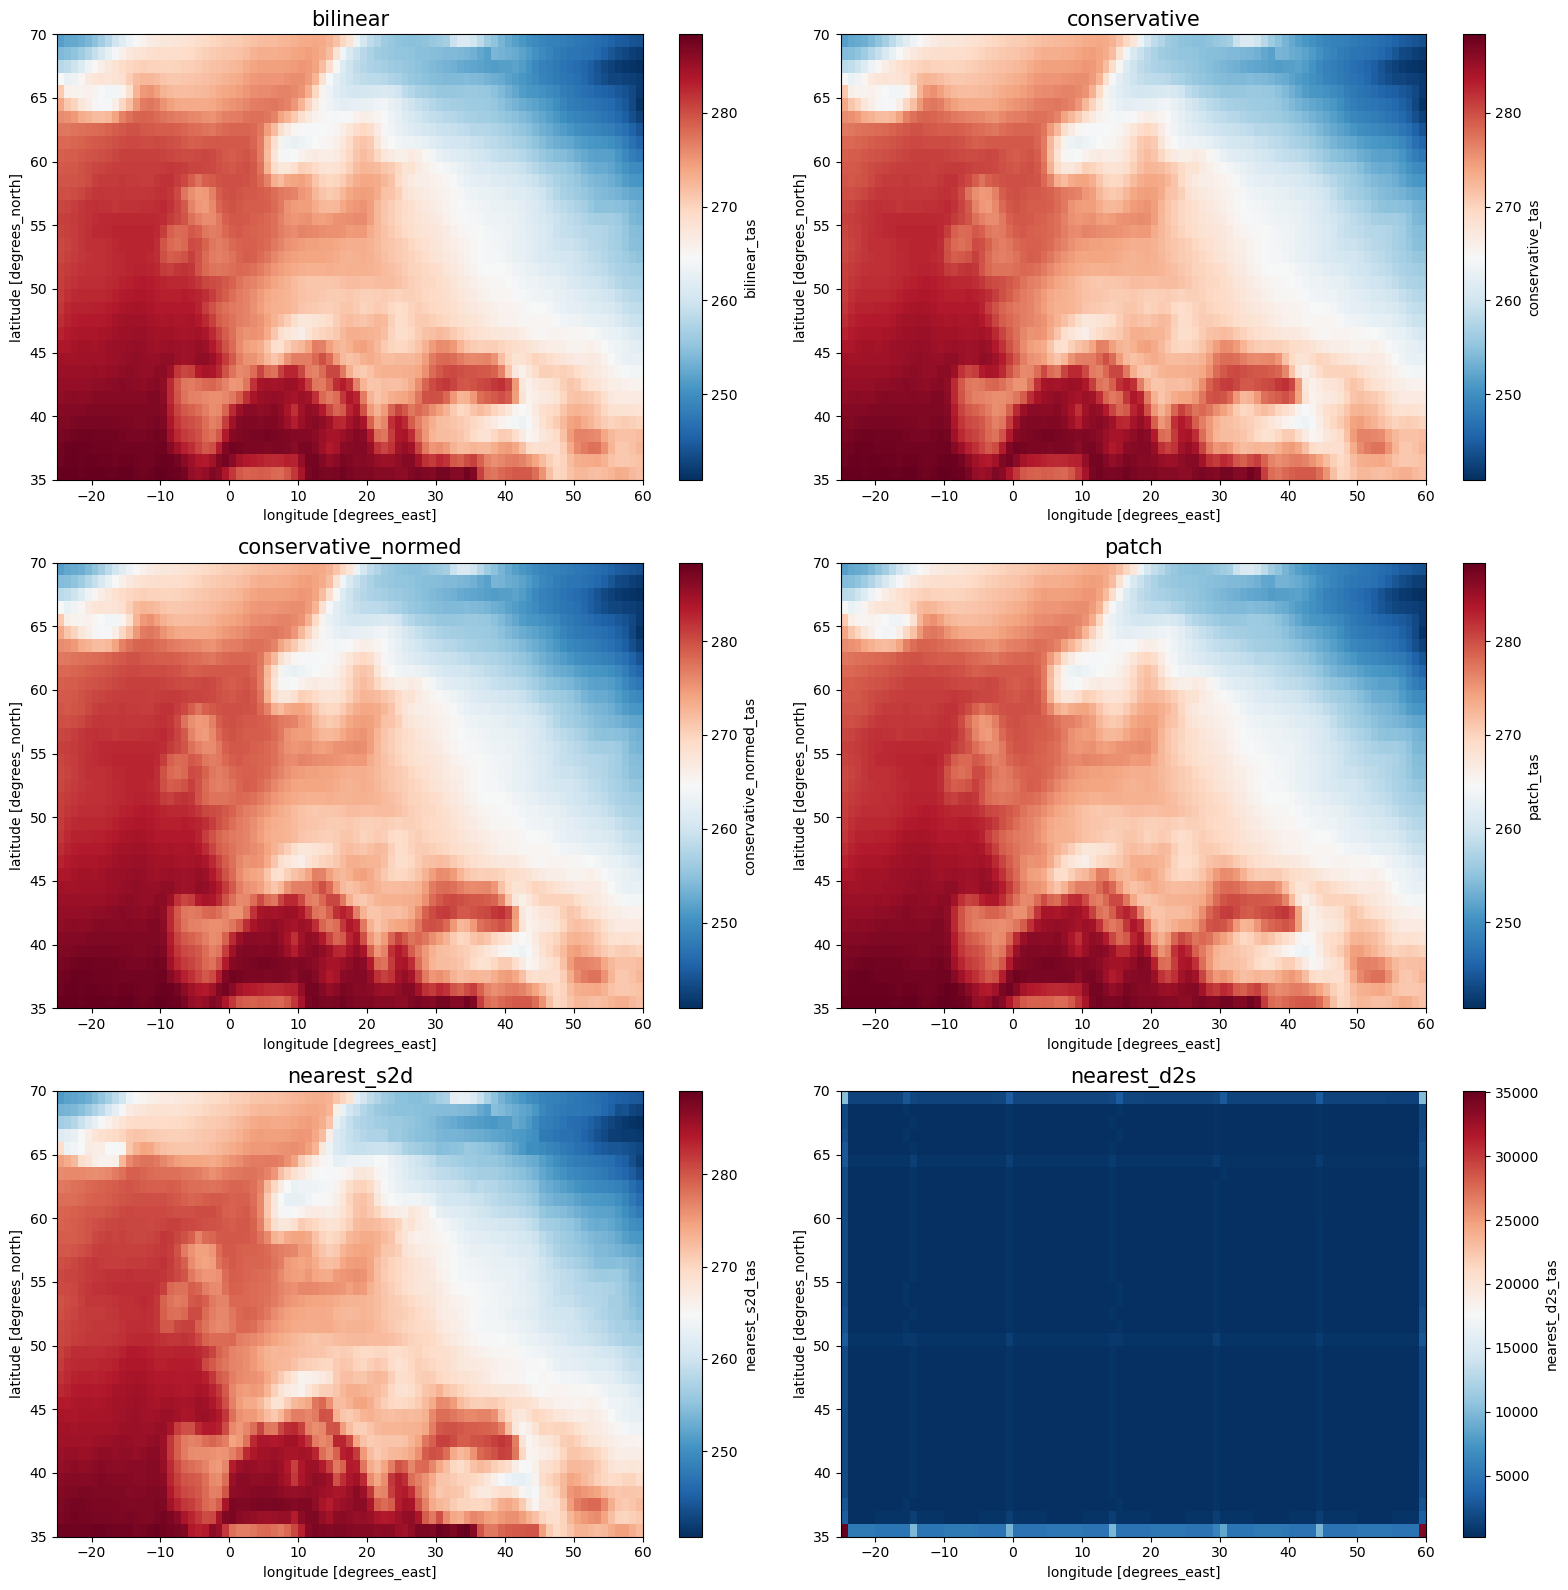

In [8]:
fig, axes = plt.subplots(3, 2, figsize=[16, 16])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_out[method+"_tas"].plot.pcolormesh(ax=ax, shading="auto", cmap="RdBu_r")
    ax.set_title(method, fontsize=15)

plt.tight_layout()

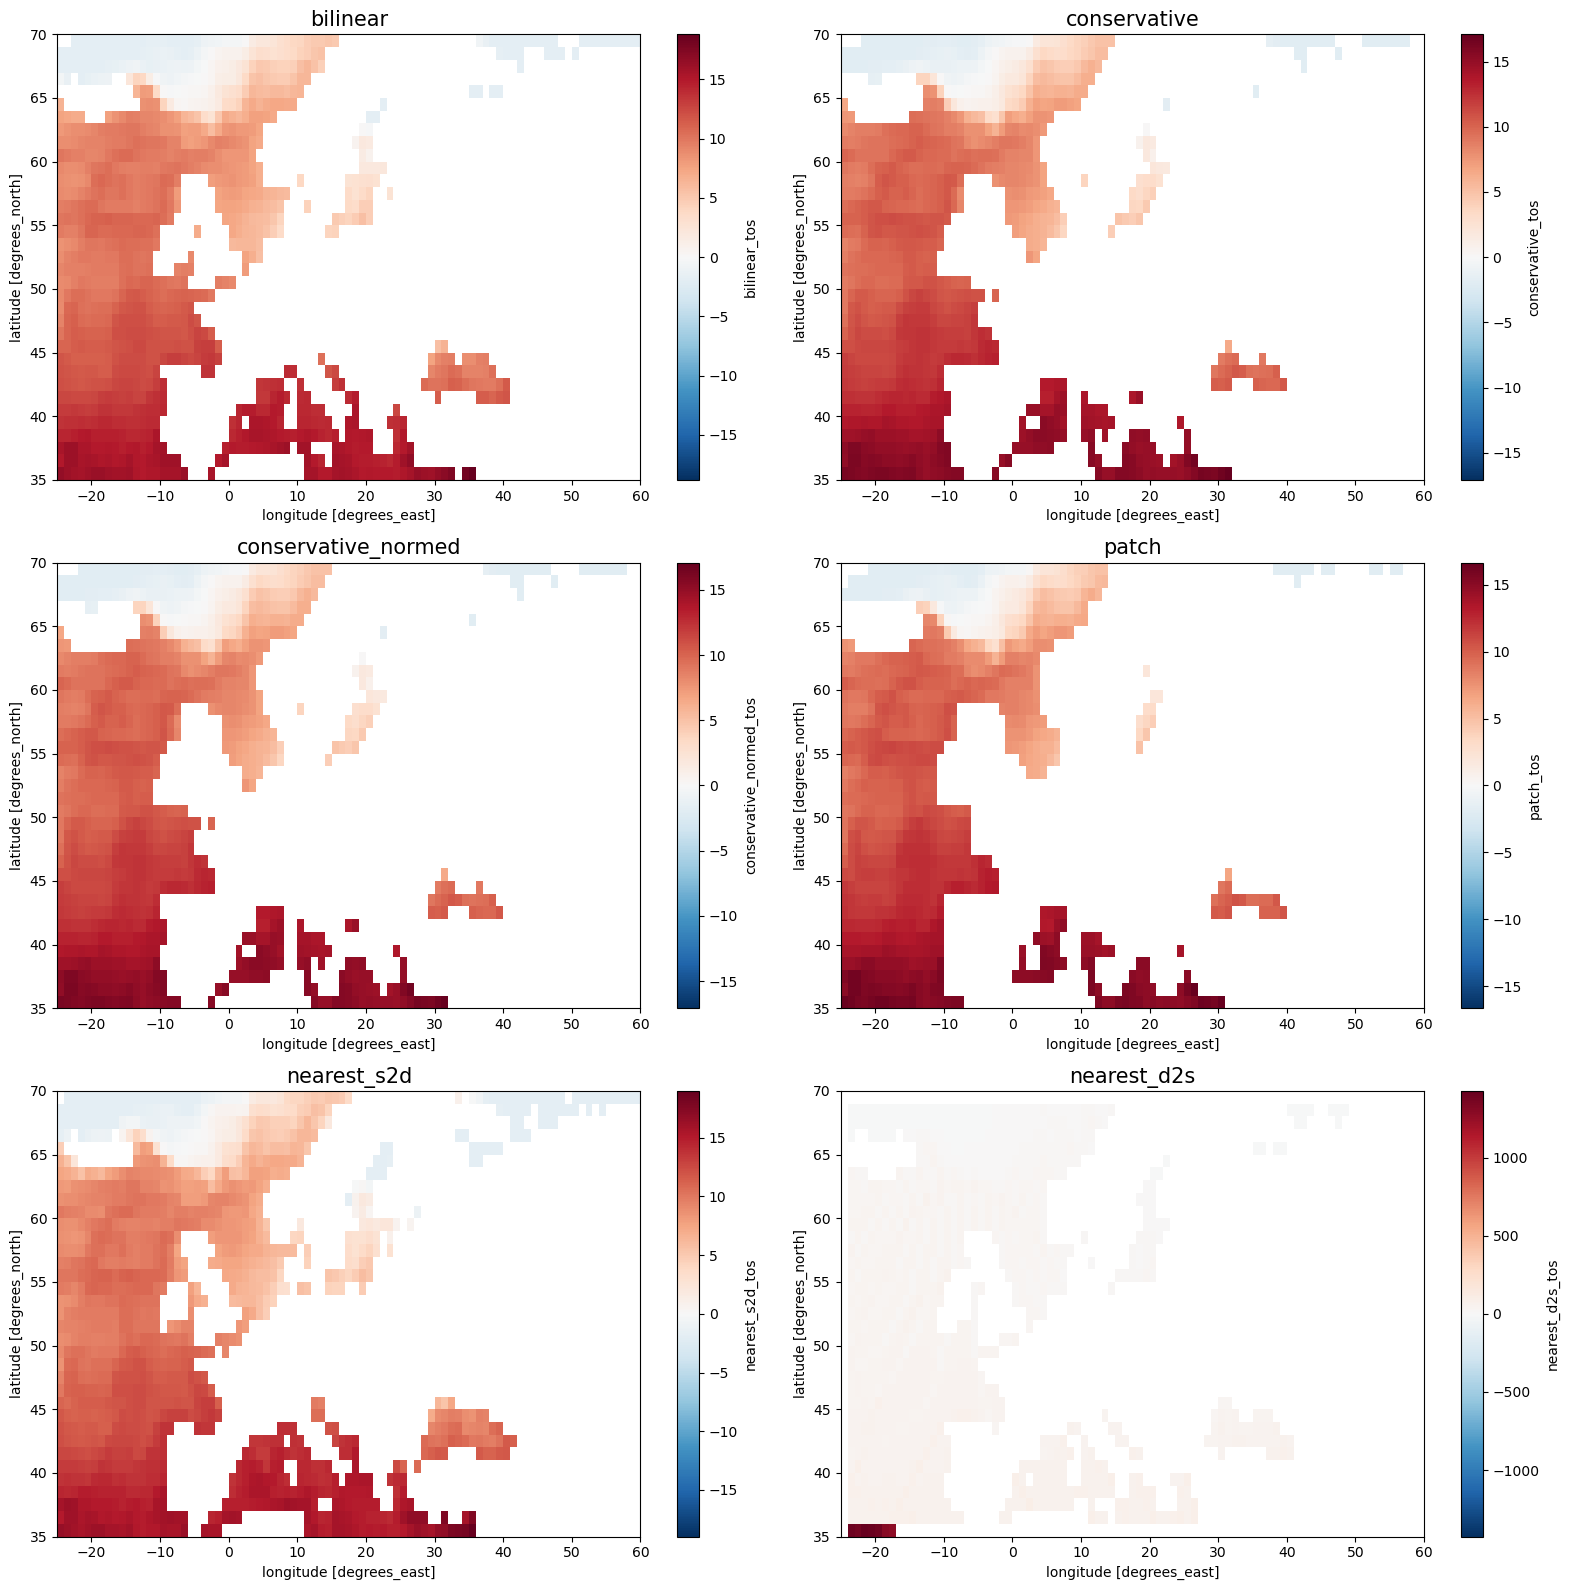

In [9]:
fig, axes = plt.subplots(3, 2, figsize=[16, 16])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_out[method+"_tos"].plot.pcolormesh(ax=ax, shading="auto", cmap="RdBu_r")
    ax.set_title(method, fontsize=15)

plt.tight_layout()

*  The missing values of the land cells are contaminating the result, since a target cell will get a missing value 
as long as only a single contributing cell of the source grid has a missing value.
*  `nearest_s2d` maps each cell of the target grid to one cell of the source grid.
*  `nearest_d2s` maps each cell of the source grid to a cell of the target grid. In case of multiple matches, which is usually the case for upscaling, the values will be added up.

## Masking

### Use an input mask to obtain a better result

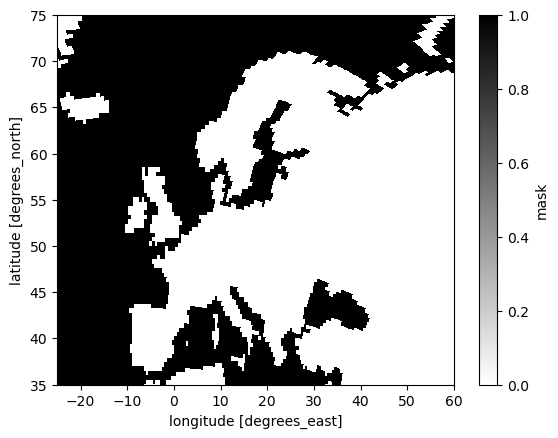

In [10]:
# Create the mask - it has to be labeled "mask"
import numpy as np
ds_tos["mask"] = xr.where(~np.isnan(ds_tos["tos"].isel(time=0)), 1, 0)
ds_tos["mask"].plot.pcolormesh(x="longitude", y="latitude", shading="auto",
                               cmap="binary", xlim=(-25,60), ylim=(35,75));

In [11]:
# Create the weights
for method in method_list:
    regridder[method+"_tos_mask"] = xe.Regridder(ds_tos, ds_out, method)

/home/k/k202015/.conda/envs/sschool/lib/python3.10/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


In [12]:
# Regrid the data
for method in method_list:
    ds_out[method+"_tos_mask"] = regridder[method+"_tos_mask"](ds_tos.tos.isel(time=0))

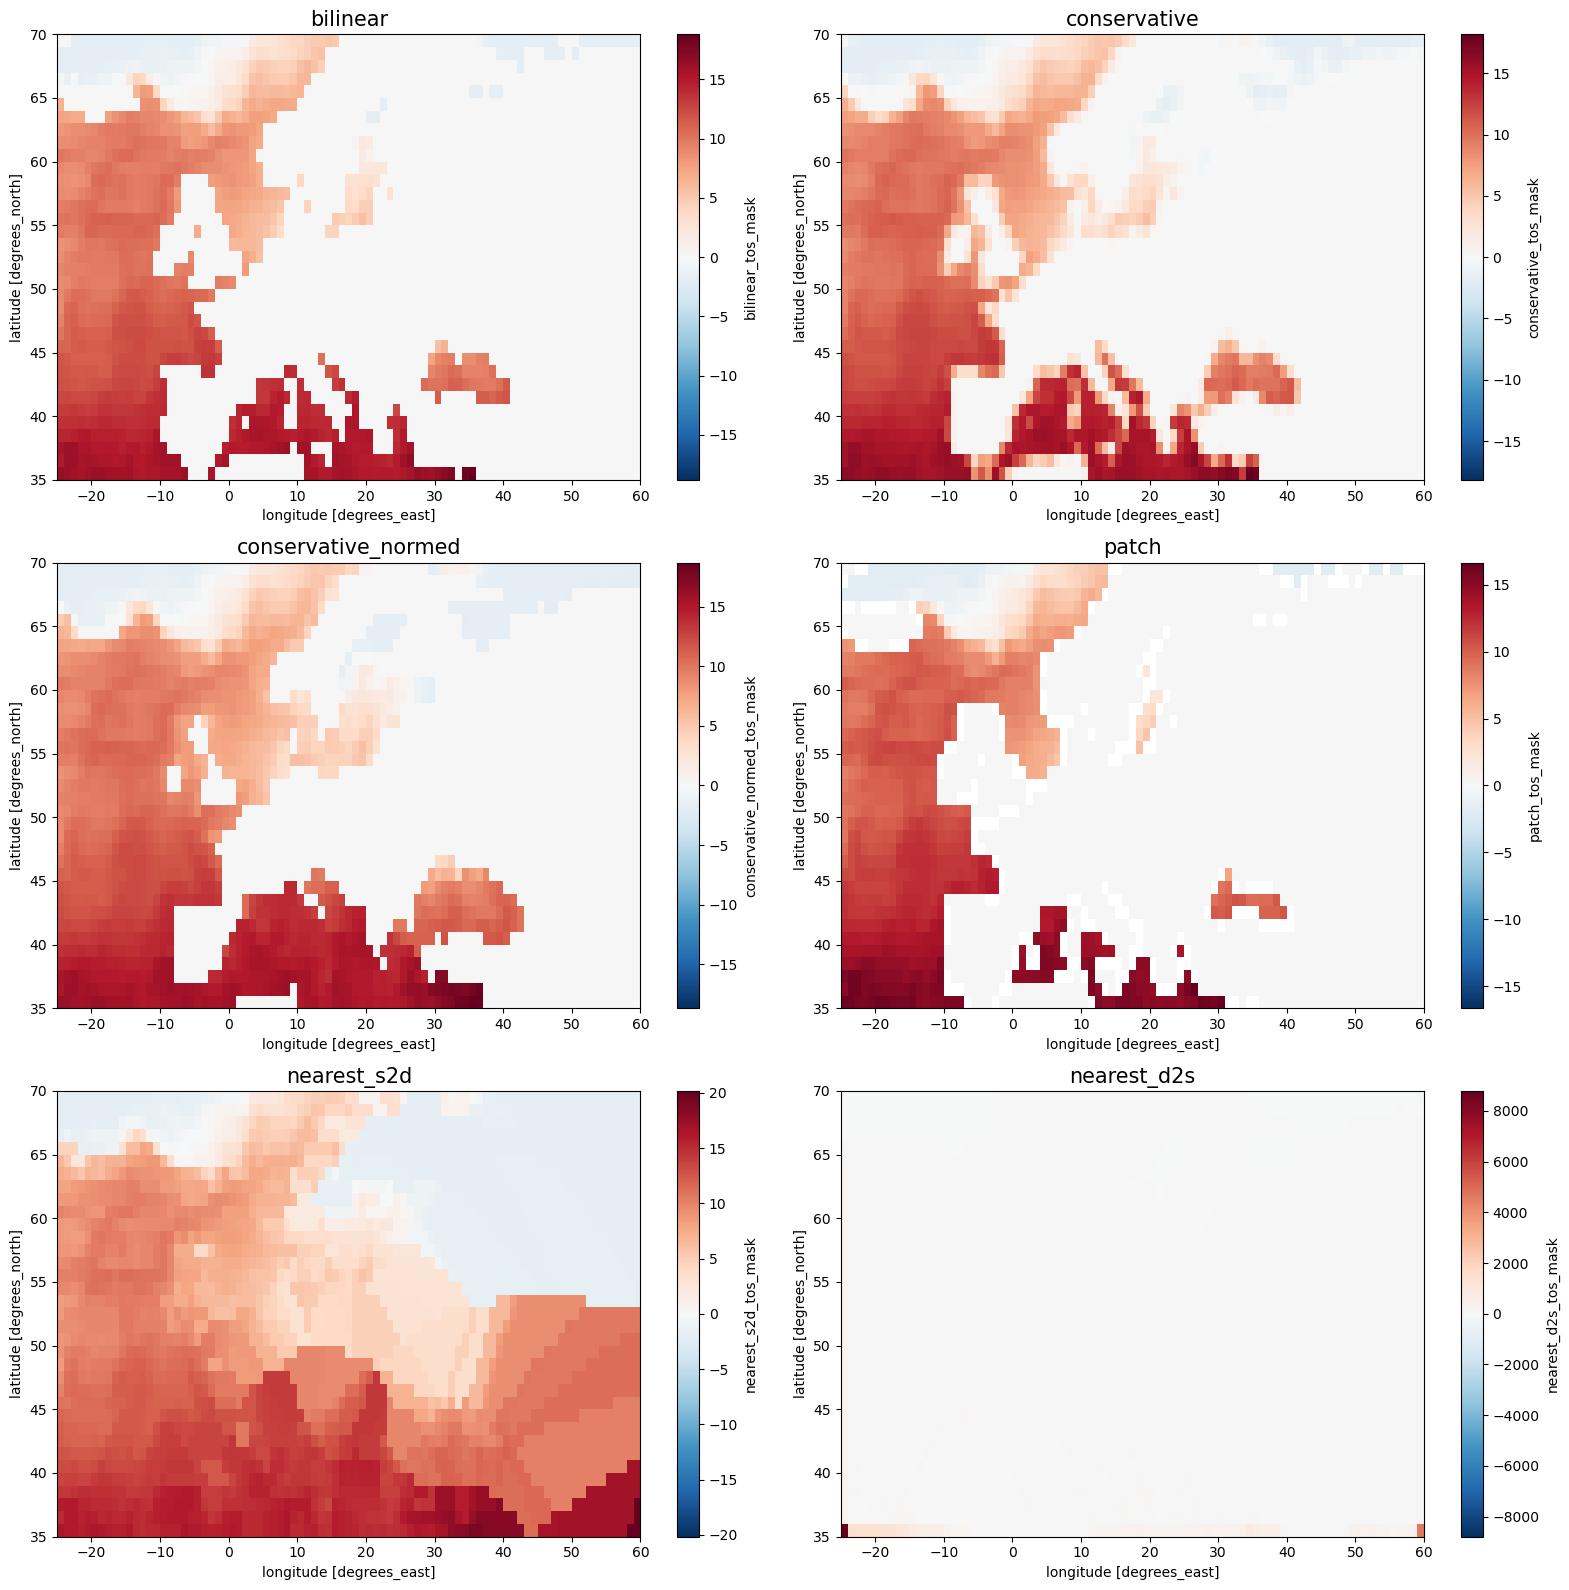

In [13]:
# Plot
fig, axes = plt.subplots(3, 2, figsize=[16, 16])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_out[method+"_tos_mask"].plot.pcolormesh(ax=ax, shading="auto", cmap="RdBu_r")
    ax.set_title(method, fontsize=15)

plt.tight_layout()

*  conservative: the values near the coastline are too low since masked cells contribute to the area average with value 0
*  conservative_normed: here a renormalization is performed for these cells
*  nearest_s2d: cells on land have the same value as the closest unmasked source grid cell

### Instead of an input mask, apply adaptive masking

The `skipna` parameter (boolean, default: False) will cause cells with missing values to be ignored.
Additionally, a renormalization is conducted. Adaptive masking has no effect for the nearest neighbour remapping methods.

The parameter `na_thres` (numeric, default: 1.0) 
allows to specify a maximum ratio of occuring missing values, up to which to apply this *adaptive masking* technique.
If set to 1.0, no target grid cell that has any contribution of a souce grid cell will be set to missing_value. In rare cases this can lead to weird results for single cells with the bilinear and patch remapping methods.
If set to 0.0, the target grid cell will be set to missing_value if any contributing cell of the source grid is missing. 

A big advantage over the input mask approach is, that weights can be reused for input data on the same grid if it is masked differently
(eg. 3D ocean data with the land sea mask varying with depth, 3D atmospheric data with orography varying with height, time dependent masks, ...).

In [14]:
# We reuse the weights created above and store the remapped datasets in the same output dataset
for method in method_list:
    ds_out[method+"_tos_skipna"] = regridder[method+"_tos"](ds_tos.tos.isel(time=0), skipna=True, na_thres=0.3)

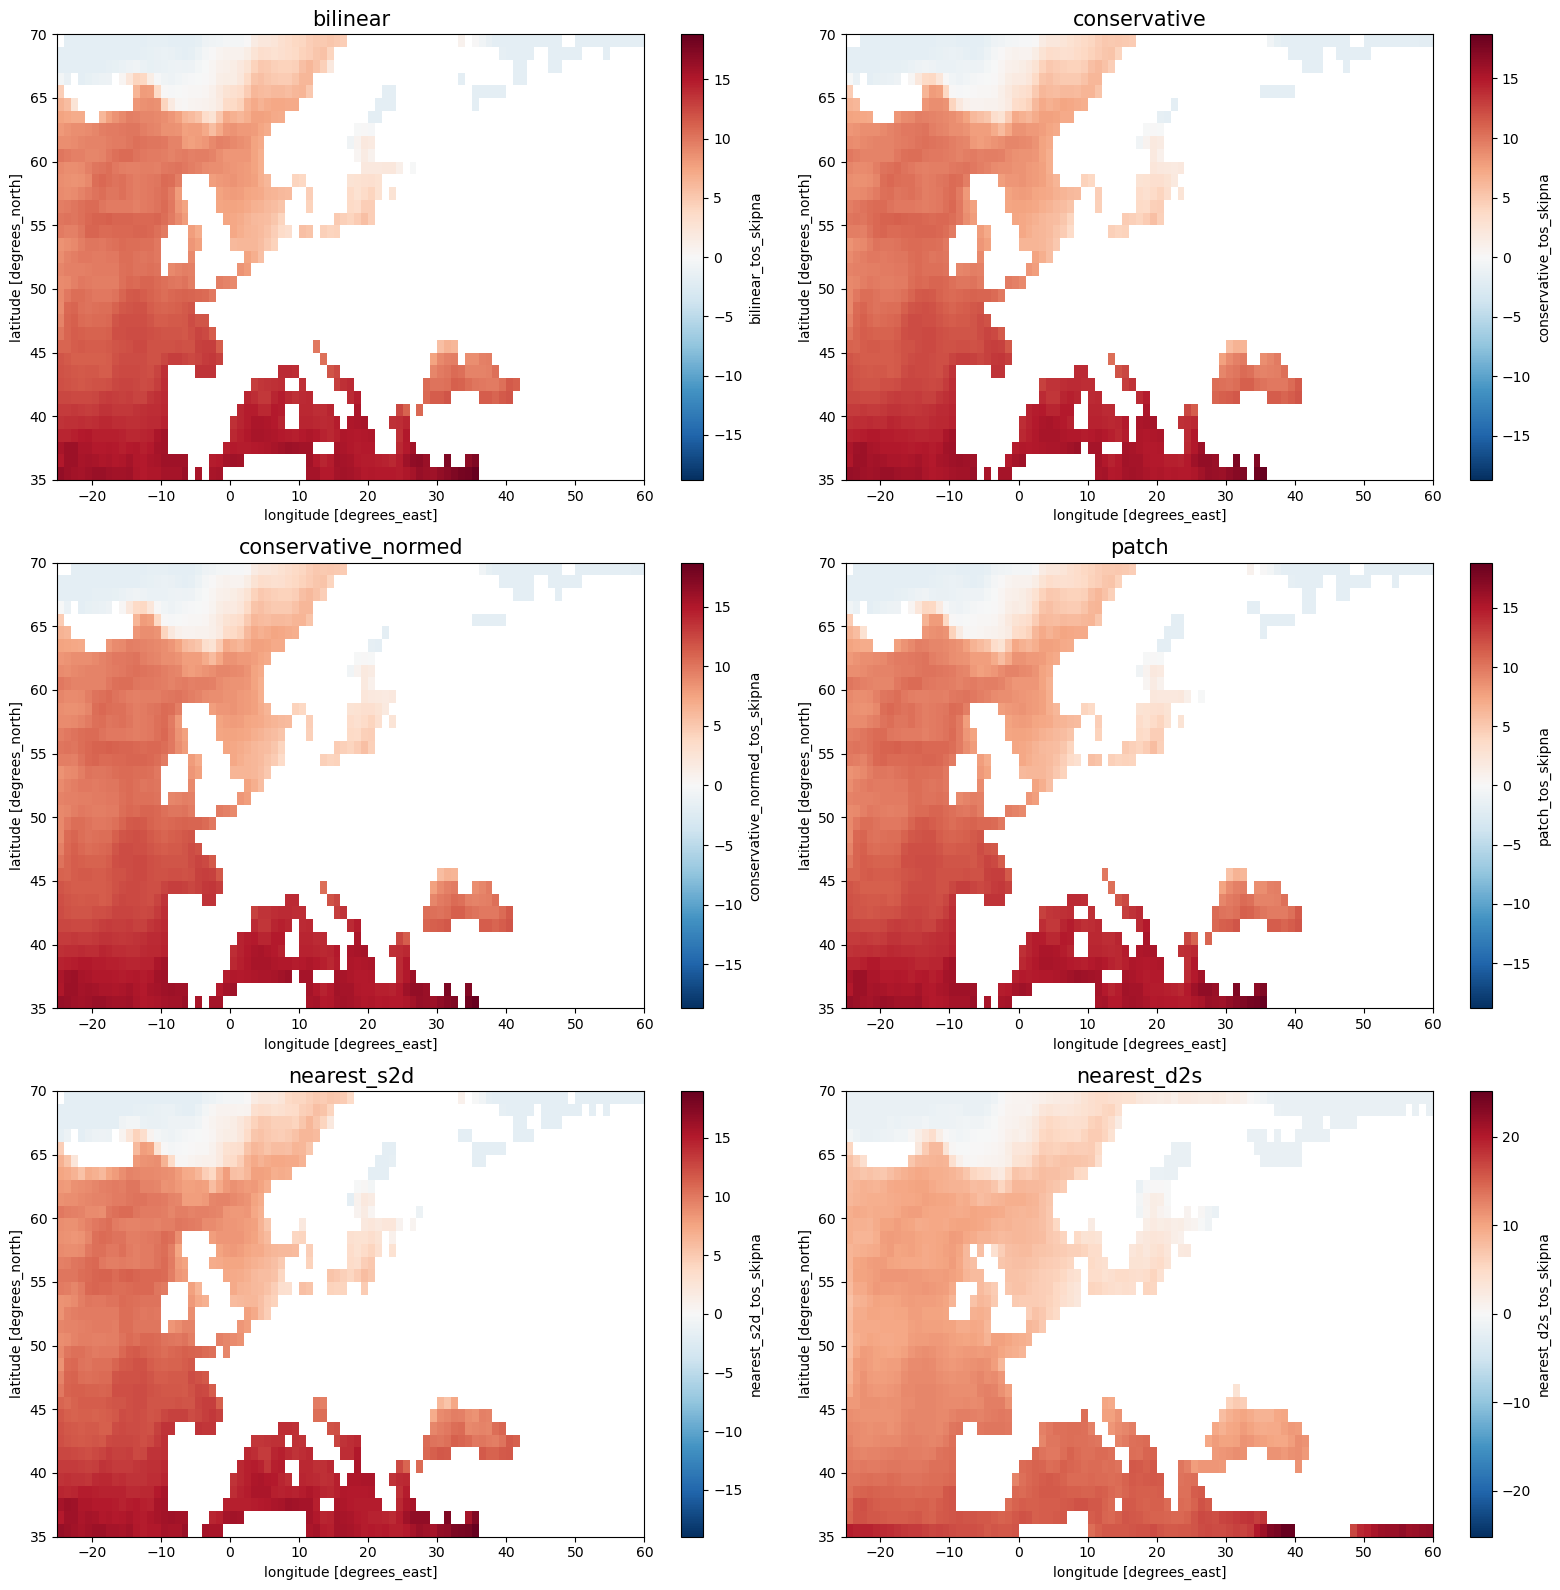

In [15]:
fig, axes = plt.subplots(3, 2, figsize=[16, 16])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_out[method+"_tos_skipna"].plot.pcolormesh(ax=ax, shading="auto", cmap="RdBu_r")
    ax.set_title(method, fontsize=15)

plt.tight_layout()

The adaptive masking technique is best applied for the conservative and patch remapping methods, 
especially when upscaling (remapping to a coarser grid). 

If `skipna=True, na_thres=1.0` are set, the conservative method yields the same result as the conservative_normed method 
with a defined input mask.

## Regridding of the global dataset

If you tried to remap the global sea surface temperature dataset you will have noticed that the weights generation
is not possible for most of the methods. This is because the dataset still contains the grid halo, 
which are duplicated rows or columns at the edge of the grid, which are necessary during the model simulation, but not so much
in the final data product. On top of that, many grid halos have collapsing bounds (i.e. collapsing on a line or point) and this 
causes (x)ESMF to crash when calculating the weights.

The CDO operator `verifygrid` is very useful in detecting duplicated and collapsing cells.

The xESMF Regridder features the parameter `ignore_degenerate` to deal with collapsing cells, but when using the patch or conservative methods,
the halo would still distort the results, since the halo cells are added up. 
One can use xarray to remove the halo or the input mask option of xESMF to mask the halo (see eg. [this notebook](https://nbviewer.jupyter.org/github/roocs/regrid-prototype/blob/main/docs/notebooks/xESMF_Behaviour_Halo.ipynb) ).

In [16]:
# Display the dataset
ds_tos_global

<xarray.Dataset>
Dimensions:             (time: 60, bnds: 2, j: 404, i: 802, vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1854-12...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 397 398 399 400 401 402 403
  * i                   (i) int32 0 1 2 3 4 5 6 ... 795 796 797 798 799 800 801
    latitude            (j, i) float64 51.15 51.15 51.15 ... -78.67 -78.67
    longitude           (j, i) float64 83.1 83.06 83.01 ... 82.4 82.85 83.3
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] ...
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    tos                 (time, j, i) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/ccd8388f-4f80-4a1e-ba47-66fe65bbeece

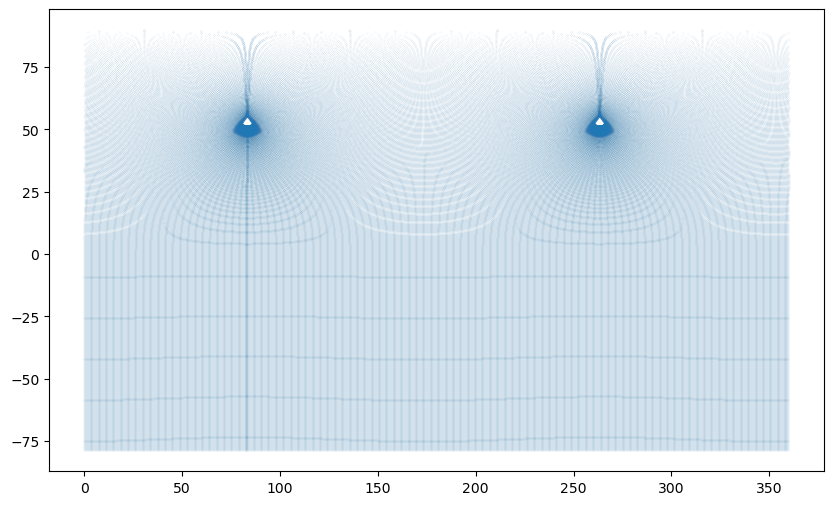

In [17]:
# Let us take a look at the grid, the halo can be spotted:
plt.figure(figsize=(10, 6))
plt.scatter(x=ds_tos_global["longitude"], y=ds_tos_global["latitude"], s=0.001);

In [18]:
# Use cdo verifygrid to confirm duplicated and/or collapsing cells
! cdo verifygrid {path_tos}

cdo    verifygrid: Grid consists of 324008 (802x404) cells (type: curvilinear), of which
cdo    verifygrid:    324008 cells have 4 vertices
cdo    verifygrid:       404 cells have duplicate vertices
cdo    verifygrid:      2408 cells are not unique
cdo    verifygrid:       404 cells are non-convex
cdo    verifygrid:       884 cells have their center point located outside their boundaries
cdo    verifygrid:  longitude : 0.00591556 to 359.9989 degrees
cdo    verifygrid:   latitude : -78.71779 to 89.76312 degrees
cdo    verifygrid: Processed 1 variable [0.21s 333MB].


In [19]:
# The halo of the MPIOM GR15 grid (MPI-ESM1-2-LR) consists of the first and last column, 
#  the halo of the MPIOM TP04 grid (MPI-ESM1-2-HR) consists of the first and last column as well as the first two rows
#  (in case it is not obvious as in the latter case, one would have to ask the modelers how their halo is defined ...)
ds_tos_nohalo = ds_tos_global.isel(i=slice(1,801), j=slice(2,405))
ds_tos_nohalo

<xarray.Dataset>
Dimensions:             (time: 60, bnds: 2, j: 402, i: 800, vertices: 4)
Coordinates:
  * time                (time) datetime64[ns] 1850-01-16T12:00:00 ... 1854-12...
  * j                   (j) int32 2 3 4 5 6 7 8 ... 397 398 399 400 401 402 403
  * i                   (i) int32 1 2 3 4 5 6 7 ... 794 795 796 797 798 799 800
    latitude            (j, i) float64 51.25 51.25 51.25 ... -78.67 -78.67
    longitude           (j, i) float64 83.1 83.14 83.19 ... 81.95 82.4 82.85
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) datetime64[ns] 1850-01-01 ... 1855-01-01
    vertices_latitude   (j, i, vertices) float64 ...
    vertices_longitude  (j, i, vertices) float64 ...
    tos                 (time, j, i) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    contact:                cmip6-mpi-esm@dkrz.de
    ...                     ...
    title:                  MPI-ESM1-2-HR output prepared for CMIP6
    variable_id:            tos
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/ccd8388f-4f80-4a1e-ba47-66fe65bbeece

In [20]:
# Use cdo selindexbox,lon_idx1,lon_idx2,lat_idx1,lat_idx2 (indexing starts at 1!)
#  to remove halo and verifygrid to confirm duplicated and/or collapsing cells have been removed
! cdo verifygrid -selindexbox,2,801,3,404 {path_tos}

cdo(1) selindexbox: Process started
cdo    verifygrid: Grid consists of 321600 (800x402) cells (type: curvilinear), of which
cdo    verifygrid:    321600 cells have 4 vertices
cdo    verifygrid:  longitude : 0.00591556 to 359.9989 degrees
cdo    verifygrid:   latitude : -78.71779 to 89.76312 degrees
cdo(1) selindexbox: Processed 19440480 values from 1 variable over 60 timesteps.
cdo    verifygrid: Processed 1 variable [0.53s 333MB].


Now one can remap the global dataset:

In [21]:
# Create global target grid
ds_out_global = xe.util.grid_global(d_lat=1, d_lon=1, cf=True)

In [22]:
# Create the remapping weights (taking a while to calculate)
#  for global datasets, we need to set the periodic parameter, or we might get missing values
#  contaminating the result where the east and west edges of the grid meet, or at the poles.
for method in method_list:
    print("\n"+method)
    %time regridder[method+"_tos_global"] = xe.Regridder(ds_tos_nohalo, ds_out_global, method, periodic=True)
    #In case one wants to see the halo effects:
    #regridder[method+"_tos_global"] = xe.Regridder(ds_tos_global, ds_out_global, method, periodic=True, ignore_degenerate=True)


bilinear


/home/k/k202015/.conda/envs/sschool/lib/python3.10/site-packages/xesmf/backend.py:38: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn('Input array is not F_CONTIGUOUS. ' 'Will affect performance.')


CPU times: user 11 s, sys: 339 ms, total: 11.3 s
Wall time: 11.4 s

conservative
CPU times: user 6.88 s, sys: 51.6 ms, total: 6.93 s
Wall time: 6.95 s

conservative_normed
CPU times: user 6.83 s, sys: 36.6 ms, total: 6.87 s
Wall time: 6.89 s

patch
CPU times: user 2min 44s, sys: 338 ms, total: 2min 44s
Wall time: 2min 45s

nearest_s2d
CPU times: user 644 ms, sys: 0 ns, total: 644 ms
Wall time: 645 ms

nearest_d2s
CPU times: user 1.1 s, sys: 0 ns, total: 1.1 s
Wall time: 1.11 s


In [23]:
# Conduct the remapping
for method in method_list:
    ds_out_global[method+"_tos_global_skipna"] = regridder[method+"_tos_global"](ds_tos_nohalo.tos.isel(time=0), skipna=True, na_thres=0.3)
    # In case one wants to see the halo effects (the proper weights must have been generated in the cell above):
    #ds_out_global[method+"_tos_global_skipna"] = regridder[method+"_tos_global"](ds_tos_global.tos.isel(time=0), skipna=True, na_thres=0.3)

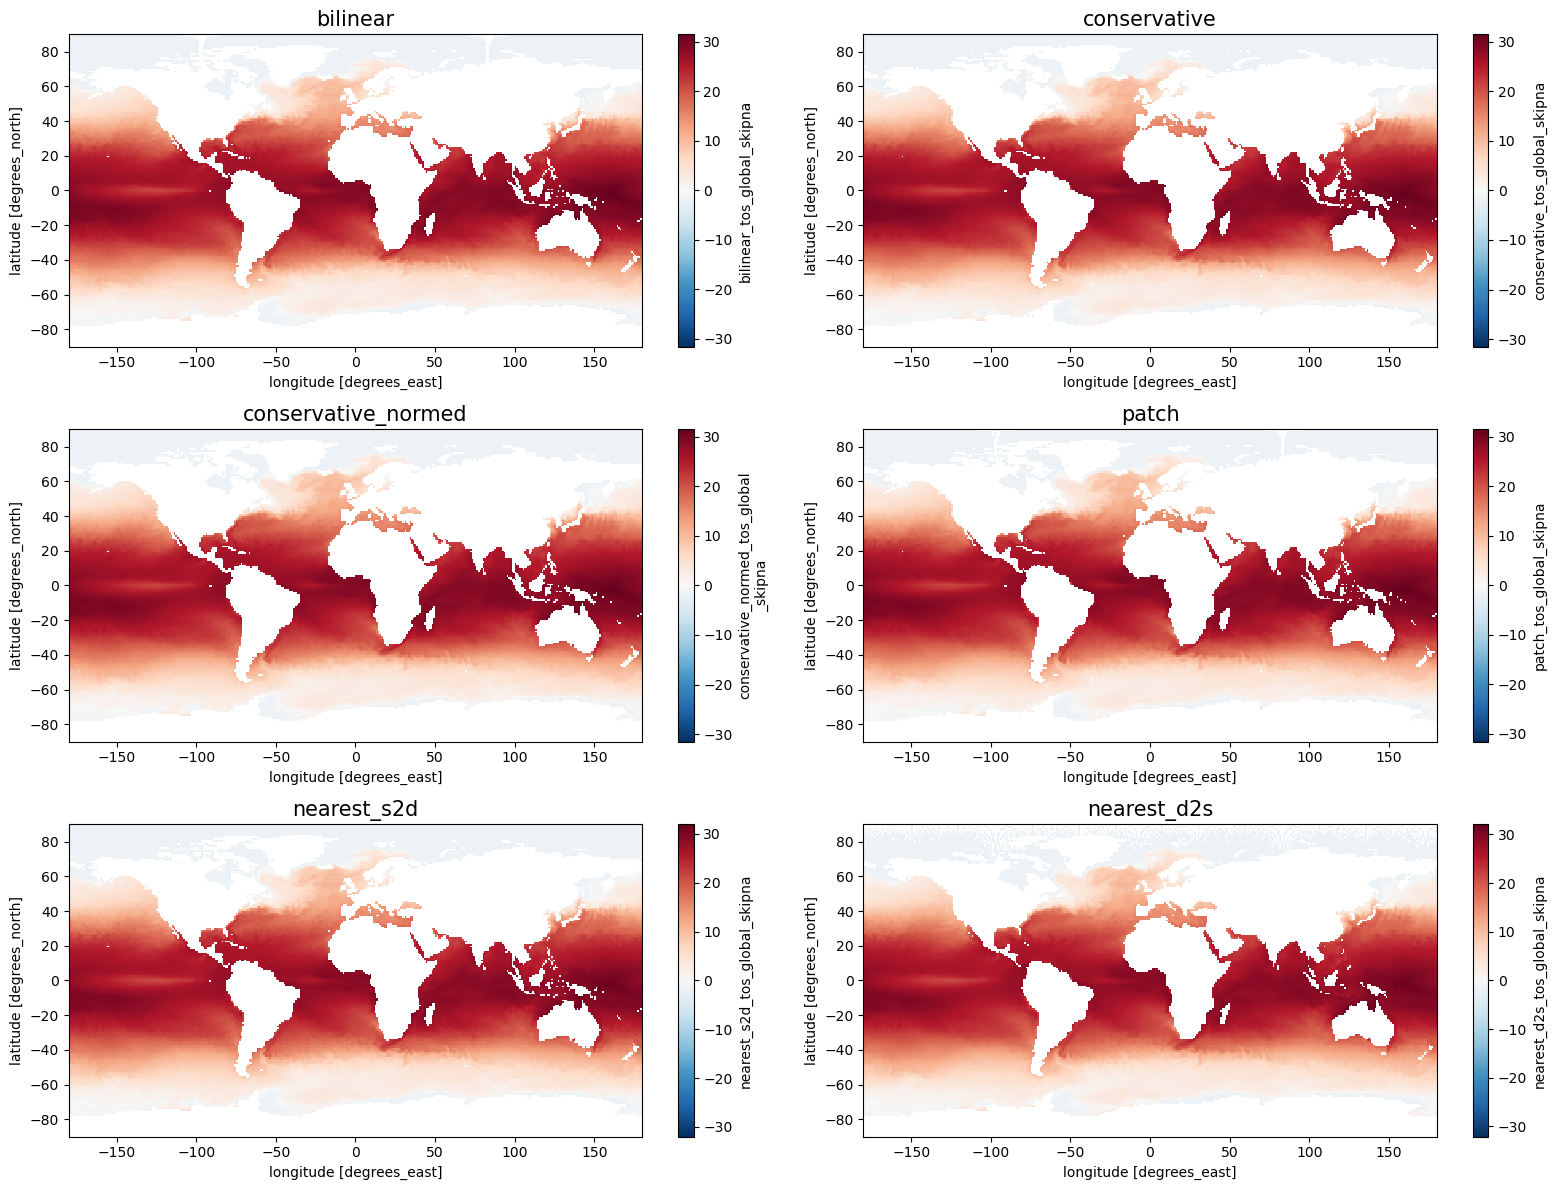

In [24]:
# Plot
fig, axes = plt.subplots(3, 2, figsize=[16, 12])

for i, method in enumerate(method_list):
    ax = axes.flatten()[i]
    ds_out_global[method+"_tos_global_skipna"].plot.pcolormesh(ax=ax, shading="auto", cmap="RdBu_r")
    ax.set_title(method, fontsize=15)

plt.tight_layout()

## More Examples

For more examples see:

*  the extensive [xESMF documentation](https://xesmf.readthedocs.io/en/latest/)
*  this selection of jupyter notebooks:
   *  [Remapping climate data with xESMF](https://nbviewer.jupyter.org/github/Ouranosinc/pavics-sdi/blob/master/docs/source/notebooks/regridding.ipynb) provided by [Ouranos](https://www.ouranos.ca/en/)
   *  [Working with GCM data](https://earth-env-data-science.github.io/lectures/working_with_gcm_data.html)
   *  [Remapping regional datasets](https://nbviewer.org/github/roocs/regrid-prototype/blob/main/docs/notebooks/xESMF_curvilinear_nearest_mask_unmapped.ipynb)
   *  [Remapping from unstructured grids](https://nbviewer.org/github/roocs/regrid-prototype/blob/main/docs/notebooks/xESMF_unstructured_locstream_ref.ipynb)
   *  [Regridding with clisops powered by xESMF](https://nbviewer.org/github/roocs/clisops/blob/regrid-main/notebooks/regrid.ipynb)
   *  [Pitfall grid halos when remapping](https://nbviewer.jupyter.org/github/roocs/regrid-prototype/blob/main/docs/notebooks/xESMF_Behaviour_Halo.ipynb)